In [3]:
import torch
import numpy as np
import pandas as pd
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline

In [5]:
words = pd.read_table('names.txt', header = None, names = ['name'])
words[:5]

,name
0,emma
1,olivia
2,ava
3,isabella
4,sophia


In [15]:
chars = sorted(list(set(''.join(words['name']))))
char_to_idx = {s:i+1 for i, s in enumerate(chars)}
char_to_idx['.'] = 0
idx_to_char = {s:i for i,s in char_to_idx.items()}
vocab_size = len(idx_to_char)

In [8]:
import random

all_names = words['name']
random.shuffle(all_names)

In [70]:
def build_dataset(words, block_size = 3):
    # first, initialize X and Y sets
    X, Y = [], []

    for w in words:
        # use the 3 previous characters to predict the next character (similar to trigram approach):
        context = [0] * block_size
        for ch in w + '.':
            idx = char_to_idx[ch]
            X.append(context)
            Y.append(idx)
            context = context[1:] + [idx]

    X, Y = torch.tensor(X), torch.tensor(Y)

    return X, Y

def build_model(vocab_size, n_emb, n_hidden, block_size = 3):
    # initialize the parameters of the model
    C = torch.randn((vocab_size, n_emb))

    # to initialize these, let's use Kaiming's Normalization numbers
    W1 = torch.randn((n_emb * block_size, n_hidden)) * (5/3)/(n_emb * block_size) ** 0.5
    # b1 = torch.randn(n_hidden) * 0.1
    W2 = torch.randn((n_hidden, vocab_size)) * 0.1
    b2 = torch.randn(vocab_size) * 0.01
    bngain = torch.ones((1, n_hidden))
    bnbias = torch.zeros((1, n_hidden))    
    bnmean_running = torch.zeros((1, n_hidden))
    bnstd_running = torch.ones((1, n_hidden))

    return [C, W1, W2, b2, bngain, bnbias], [bnmean_running, bnstd_running]

def train_model(Xtr, Ytr, grad_parameters, running_parameters, batch_size = 32, learning_rate = 0.1, epochs = 20000):
    C, W1, W2, b2, bngain, bnbias = grad_parameters
    bnmean_running, bnstd_running = running_parameters

    loss_i = []

    for p in grad_parameters:
        p.requires_grad = True

    for _ in range(epochs):
        # implement stochastc gradient descent to train the model
        ix = torch.randint(0, Xtr.shape[0], (batch_size,))

        # embedding vector
        emb = C[Xtr[ix]]

        # first layer
        embcat = emb.view(emb.shape[0], -1)

        # make the numbers roughy Gaussian with batch normalization
        hpreact = embcat @ W1 #+ b1
        bn_mean = hpreact.mean(dim = 0, keepdim = True)
        bn_std = hpreact.std(dim = 0, keepdim = True)
        hpreact = bngain * (hpreact - bn_mean) / bn_std + bnbias

        with torch.no_grad():
            bnmean_running = 0.99 * bnmean_running + 0.01 * bn_mean
            bnstd_running = 0.99 * bnstd_running + 0.01 * bn_std

        h = torch.tanh(hpreact)

        # second layer (non-linaerity)
        logits = (h @ W2) + b2

        # cross entropy loss
        loss = F.cross_entropy(logits, Ytr[ix])

        # make sure gradients aren't adding on top of each other
        for p in grad_parameters:
            p.grad = None
        
        # backwards pass
        loss.backward()

        # update parameters
        if _ // 10000 == 1:
            learning_rate = 0.01

        for p in grad_parameters:
            p.data -= learning_rate * p.grad

        # if _ % 1000 == 0:
        #     print(f'{_:7d}/{epochs:7d}: {loss.item():.4f}')
        loss_i.append(np.log10(loss.item()))

    # plot the loss
    plt.plot(loss_i)
    return [C, W1, W2, b2, bngain, bnbias], [bnmean_running, bnstd_running]

def eval(grad_parameters, running_parameters):
    C, W1, W2, b2, bngain, bnbias = grad_parameters
    bnmean_running, bnstd_running = running_parameters

    @torch.no_grad() # this decorator disables gradient tracking

    def split_loss(split):
        x,y = {
            'train': (Xtr, Ytr),
            'val': (Xval, Yval),
            'test': (Xte, Yte),
        }[split]
        emb = C[x] # (N, block_size, n_embd)
        embcat = emb.view(emb.shape[0], -1) # concat into (N, block_size * n_embd)
        hpreact = embcat @ W1 #+ b1
        hpreact = bngain * (hpreact - bnmean_running) / (bnstd_running + 1e-5) + bnbias
        h = torch.tanh(hpreact) # (N, n_hidden)
        logits = h @ W2 + b2 # (N, vocab_size)
        loss = F.cross_entropy(logits, y)
        print(split, loss.item())

    split_loss('train')
    split_loss('val')
    split_loss('test')

In [71]:
# Let's train a deeper network
# The classes we create here are the same API as nn.Module in PyTorch

class Linear:
  
  def __init__(self, fan_in, fan_out, bias=True):
    self.weight = torch.randn((fan_in, fan_out)) / fan_in**0.5
    self.bias = torch.zeros(fan_out) if bias else None
  
  def __call__(self, x):
    self.out = x @ self.weight
    if self.bias is not None:
      self.out += self.bias
    return self.out
  
  def parameters(self):
    return [self.weight] + ([] if self.bias is None else [self.bias])


class BatchNorm1d:
  
  def __init__(self, dim, eps=1e-5, momentum=0.1):
    self.eps = eps
    self.momentum = momentum
    self.training = True
    # parameters (trained with backprop)
    self.gamma = torch.ones(dim)
    self.beta = torch.zeros(dim)
    # buffers (trained with a running 'momentum update')
    self.running_mean = torch.zeros(dim)
    self.running_var = torch.ones(dim)
  
  def __call__(self, x):
    # calculate the forward pass
    if self.training:
      xmean = x.mean(0, keepdim=True) # batch mean
      xvar = x.var(0, keepdim=True) # batch variance
    else:
      xmean = self.running_mean
      xvar = self.running_var
    xhat = (x - xmean) / torch.sqrt(xvar + self.eps) # normalize to unit variance
    self.out = self.gamma * xhat + self.beta

    if self.training:
      with torch.no_grad():
        # exponential moving average 
        self.running_mean = (1 - self.momentum) * self.running_mean + self.momentum * xmean
        self.running_var = (1 - self.momentum) * self.running_var + self.momentum * xvar
    return self.out
  
  def parameters(self):
    return [self.gamma, self.beta]

class Tanh:
  def __call__(self, x):
    self.out = torch.tanh(x)
    return self.out
  def parameters(self):
    return []

In [72]:
n1 = int(0.8 * words.shape[0])
n2 = int(0.9 * words.shape[0])
Xtr, Ytr = build_dataset(all_names[:n1])
Xval, Yval = build_dataset(all_names[n1:n2])
Xte, Yte = build_dataset(all_names[n2:])

In [73]:
grad_parameters, running_parameters = build_model(27, 10, 300)

In [74]:
C, W1, W2, b2, bngain, bnbias = grad_parameters
bnmean_running, bnstd_running = running_parameters

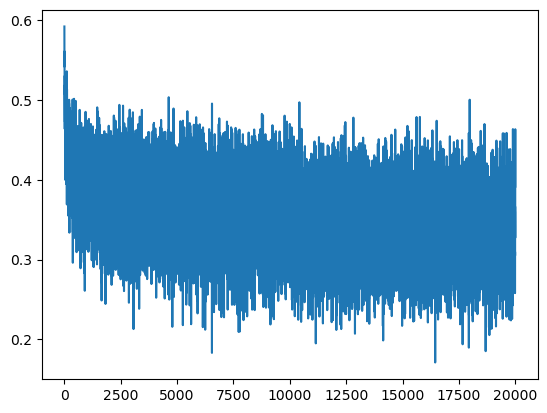

In [75]:
grad, running = train_model(Xtr, Ytr, grad_parameters, running_parameters) 

In [76]:
eval(grad, running)

train 2.169447660446167
val 2.1994245052337646
test 2.1949462890625


In [82]:
def build_layered_model(vocab_size = 27, n_emb = 10, n_hidden = 300, block_size = 3):
    C = torch.randn((vocab_size, n_emb))
    layers = [
        Linear(n_emb * block_size, n_hidden, bias = False), BatchNorm1d(n_hidden), Tanh(),
        Linear(n_hidden, vocab_size)
    ]

    with torch.no_grad():
        layers[-1].weight *= 0.1

    parameters = [C] + [p for layer in layers for p in layer.parameters()]
    for p in parameters:
        p.requires_grad = True
    
    return [parameters, layers]

def train_model(Xtr, Ytr, max_steps, batch_size, parameters, layers):
    loss_i = []
    for i in range(max_steps):
        ix = torch.randint(0, Xtr.shape[0], (batch_size,))
        Xb, Yb = Xtr[ix], Ytr[ix]
        
        C = parameters[0]
        emb = C[Xb]
        x = emb.view(emb.shape[0], -1)
        for layer in layers:
            x = layer(x)
        
        loss = F.cross_entropy(x, Yb)

        for p in parameters:
            p.grad = None
        loss.backward()

        lr = 0.1 if i < 50000 else 0.01
        for p in parameters:
            p.data -= lr * p.grad
        
        if i % 10000 == 0:
            print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
        loss_i.append(loss.log10().item())
    
    plt.plot(loss_i)
    return parameters

def evaluate_model(parameters, layers):
    C = parameters[0]
    for layer in layers:
        layer.training = False

    @torch.no_grad()
    def split_loss(split):
        x, y = {
            'train': (Xtr, Ytr),
            'val': (Xval, Yval),
            'test': (Xte, Yte)
        }[split]
        emb = C[x]
        x = emb.view(emb.shape[0], -1)
        for layer in layers:
            x = layer(x)
        loss = F.cross_entropy(x, y)
        print(f'{split}: {loss.item()}')
    
    split_loss('train')
    split_loss('val')
    split_loss('test')


In [83]:
params, layers = build_layered_model()
updated_params = train_model(Xtr, Ytr, 100000, 100, params, layers)
evaluate_model(updated_params, layers)

      0/ 100000: 3.2932
